* z, y|z
* implement knn, dt, kernel
* compare asymp

## Data

In [38]:
from scipy.stats import dirichlet
from scipy.special import softmax

In [39]:
class SimulatedData:
    def __init__(self, dim):
        self.dim = dim
        self.T = 0.6

    def pz(self, z):
        return dirichlet.pdf(z, [1] * self.dim)
    
    def py_given_z(self, z):
        return softmax(z / self.T)
    
    def sample(self, n):
        z = np.random.dirichlet([1] * self.dim, n)
        y = np.array([np.random.multinomial(1, self.py_given_z(zz)) for zz in z])
        return z, y

In [40]:
data = SimulatedData(3)
z, y = data.sample(1000)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

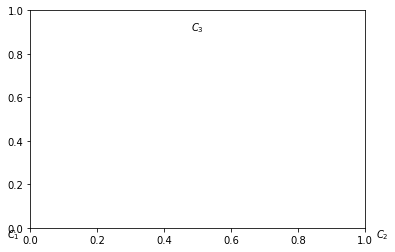

In [9]:
from pycalib.visualisations.ternary import draw_tri_samples

fig, ax = draw_tri_samples(z, classes=y, alpha=0.6)

## Model

In [41]:
from calibration import HistogramCalibrator, DecisionTreeCalibrator, KNNCalibrator, IsotonicCalibrator
from simulation_calibration import evaluate

In [42]:
calibrators = {
    "UWB": HistogramCalibrator(n_bins=10, strategy="uniform"),
    'UMB': HistogramCalibrator(n_bins=10, strategy="quantile"),
    'DT': DecisionTreeCalibrator(max_depth=4, min_samples_leaf=10), # no intra-bin continuity
    'KNN': KNNCalibrator(k=100),
    'ISO': IsotonicCalibrator(),
}

results = []
for name, calibrator in calibrators.items():
    calibrator.fit(z, y)
    metrics = evaluate(calibrator, data.py_given_z, data.pz)
    metrics.update({'name': name})
    results.append(metrics)

df = pd.DataFrame(results)
df

ValueError: object too deep for desired array

In [1]:
from sklearn.neighbors import KNeighborsRegressor

In [2]:
class KNNCalibrator:
    def __init__(self, k=5) -> None:
        self.knn = KNeighborsRegressor(n_neighbors=k)

    def fit(self, X, y):
        self.knn.fit(X, y)
        return self

    def __call__(self, X):
        return self.knn.predict(X)

## Two class

In [44]:
from simulation_label_shift import GaussianMixture
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
data = GaussianMixture(2, 0.5)
z, y = data.sample(1000)

In [46]:
from calibration import HistogramCalibrator, DecisionTreeCalibrator, KNNCalibrator, IsotonicCalibrator
from simulation_calibration import evaluate

In [47]:
calibrators = {
    "UWB": HistogramCalibrator(n_bins=10, strategy="uniform"),
    'UMB': HistogramCalibrator(n_bins=10, strategy="quantile"),
    'DT': DecisionTreeCalibrator(max_depth=4, min_samples_leaf=10), # no intra-bin continuity
    'KNN': KNNCalibrator(k=100),
    'ISO': IsotonicCalibrator(),
}

results = []
for name, calibrator in calibrators.items():
    calibrator.fit(z, y)
    metrics = evaluate(calibrator, data.py_given_z, data.pz)
    metrics.update({'name': name})
    results.append(metrics)

df = pd.DataFrame(results)
df

,cal,sha,ref,risk,bs,name
0,0.001506,0.000568,0.00251,0.002074,0.004584,UWB
1,0.000647,0.003120,0.00251,0.003767,0.006278,UMB
2,0.003444,0.000000,0.00251,0.003444,0.005955,DT
3,0.000717,0.000000,0.00251,0.000717,0.003228,KNN
4,0.001087,0.000293,0.00251,0.001380,0.003891,ISO


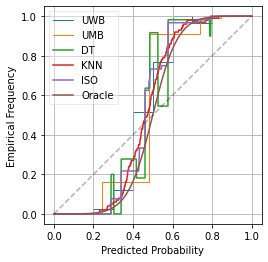

In [50]:
from calibration import OracleCalibrator


fig, ax = plt.subplots(figsize=(4,4))
for name, calibrator in calibrators.items():
    # if name not in ["KNN"]:
    #     continue
    calibrator.plot(ax=ax, label=name)
OracleCalibrator(data.py_given_z).plot(ax=ax, label="Oracle", set_layout=True)
plt.savefig('knn_dt.png', dpi=300, bbox_inches='tight')

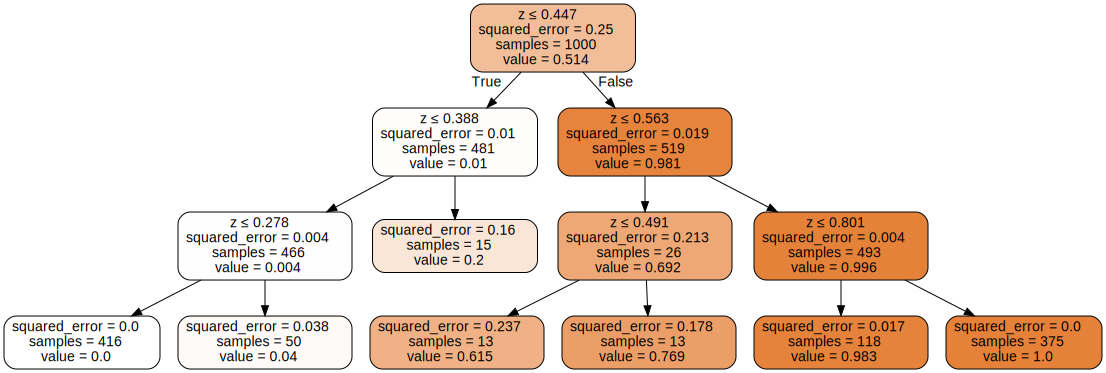

In [32]:
decision_tree_regressor = calibrators['DT'].tree
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(decision_tree_regressor, out_file=None,
                            feature_names=['z'],
                            filled=True, rounded=True,
                            special_characters=True)
graph = graphviz.Source(dot_data)
graph